# Data inspection and cleaning

Endogenous Rhythmic Attention project, 2019-2023

<b>Author</b>: Olof J. van der Werf
<br><b>Last updated</b>: 04-08-2023

### Purpose of this notebook

This notebook explores, inspects and cleans the data belonging to this project. Data inspection steps taken are:

<ul>
<li>Exploring the task log files</li>
<li>Determining outliers in the data</li>
<li>Filter data</li>
<li>Save cleaned data</li>
</ul>

### Import necessary libraries

In [1]:
import scipy.io as sio
import numpy as np
import pandas as pd
from glob import glob
import matplotlib.pyplot as plt
from scipy import stats
import warnings
warnings.filterwarnings("ignore")

### Set variables

In [2]:
# Variables

# folders containing data
raw_data_folder = 'data/raw_data'
clean_data_folder = 'data/data_after_cleaning/' 

# lists with factors
validities = ['valid','invalid']
visual_fields = ['left','right','both']
conditions = ['60','80','100']

#### Participants
<i>"A total of 32 participants (mean age: 23; range: 19-28, 22 females) participated in the study. All participants were right-handed and had normal or corrected-to-normal vision."<i/>

In [3]:
# list of all participants in this study
subjects = ['02','03','04','05','06','08','09','11','12','14','15','16','17','18','19','20','21','24','25','26','27','30','31','32','33','34','35','36','37','38','39','40']

print('Total number of participants: '+str(len(subjects)))

Total number of participants: 32


### Get the data

Loading the log files for each participant. Two files are loaded:
<ol>
    <li><b>Task log file:</b> This file contains the parameters, timings, and responses (e.g. reaction times) of each trial in the experiment.</li>
    <li><b>Eye tracker 'reject' file:</b> This file contains a row of <code>1</code>'s (reject trial) and <code>0</code>'s (keep trial), coding for above-threshold blinks and saccades as determined by the eye tracker. The MATLAB code that analyses the eye tracker files can be found in our DataVerse repository.
<br>    - Measurement: <i>"We performed video-based monocular eye tracking at 1000 Hz with the Eyelink1000 system (SR Research, Mississauga, Ontario, Canada). A standard nine-point calibration and validation procedure was used to calibrate the eye tracker."</i>
<br>    - Threshold: Trials with blinks (>100 ms) and saccades (exceeding 2° of visual angle) will be marked <code>1</code> to be rejected by our MATLAB algorithm.
    </li>
    
</ol>


In [4]:
# Save all data per subject
data = {} # dict to save data in (subjects become keys, Pandas DataFrames become values)

for subject in subjects:
    
    # Determine filename for logfile
    log_name = raw_data_folder + '/log_files/log_Posner_'+subject+'*.txt' # set file name
    log_name = glob(log_name) # check files with this name
    if len(log_name) > 1:
        raise ValueError('Whoops! Multiple files found with this name!')

    # Import log file (.txt)
    columns = ['trial','trial in block','condition','validity','cue side','target side','grating rotation bin','grating rotation deg','fixation-cue interval','cue-target interval','response key','response','reaction time']
    log = pd.read_csv(log_name[0], sep = '\t', names=columns, index_col=False, na_values = 'NaN ')

    # Import eye tracking file (.txt)
    eye_tracker_name = raw_data_folder+'/eyetracker_reject/P'+subject+'_to_reject.txt'
    eye_tracker_data = pd.read_csv(eye_tracker_name, sep = '\t',index_col=False,header=None)

    # Add eye tracking keep / reject info to logfile
    log = pd.concat([log, eye_tracker_data], axis=1, sort = True)
    log = log.rename(columns={0: "eye tracker reject"})
    
    # Timings are reported in seconds, whereas we want to report timings in milliseconds.
    # -> Multiple response times with 1000
    log['reaction time'] = log['reaction time'].multiply(1000)
    
    # Skip the practice trials (denoted with negative values in 'trial' column)
    data[subject] = log[(log['trial'] > 0)]

In [5]:
# Glimpse of how the data looks like
data['02'].head(10)

,trial,trial in block,condition,validity,cue side,target side,grating rotation bin,grating rotation deg,fixation-cue interval,cue-target interval,response key,response,reaction time,eye tracker reject
60,1,1,60,0,1,0,0,45,0.500074,1.150168,1,1,776.616,0
61,2,2,60,1,1,1,1,-45,0.649902,0.549960,2,1,459.128,0
62,3,3,60,0,0,1,0,45,0.516963,0.633307,0,0,1000.000,0
63,4,4,60,0,0,1,0,45,0.433615,1.516787,1,1,847.259,1
64,5,5,60,0,0,1,1,-45,0.616566,1.566614,2,1,717.843,0
65,6,6,60,1,1,1,0,45,0.466614,0.783174,1,1,776.632,0
66,7,7,60,1,1,1,1,-45,0.750250,1.166596,2,1,482.557,0
67,8,8,60,0,1,0,1,-45,0.666756,1.383294,2,1,621.612,0
68,9,9,60,1,0,0,0,45,0.733387,1.166710,2,0,657.366,0
69,10,10,60,0,0,1,1,-45,0.700043,0.933346,2,1,529.812,0


Above is a glimpse of how the data looks like. Variable codes:
* **trial**: Total trial number
* **trial in block**: Trial number, this number resets per block (there are 6 blocks, 2 blocks per condition)
* **condition**: Cue validity condition (in %)
* **validity**: Whether the cue was valid (<code>1</code>) or not (<code>0</code>)
* **cue side**: Whether the cue pointed to the left (<code>0</code>) or the right (<code>1</code>)
* **target side**: Whether the target was located left (<code>0</code>) or right (<code>1</code>)
* **grating rotation bin**: Whether the grating was oriented 45 deg (<code>0</code>) or -45 deg (<code>1</code>)
* **grating rotation deg**: Grating orientation in degrees
* **fixation-cue interval**: The interval between the fixation cross and the cue, as timestamped by task, in ms
* **cue-target interval**: The interval between the cue and the target, as timestamped by task, in ms
* **response key**: Whether the left (<code>1</code>) or right (<code>2</code>) button was pressed
* **response correct**: Whether the response was correct (<code>1</code>) or not (<code>0</code>)
* **response time**: The reaction time, in ms
* **eye tracker reject**: Whether this trial was rejected (<code>1</code>) due to blinks and saccades, or not (<code>0</code>)

### Outliers in terms of blinks & saccades

Here, each participant log file is checked for the amount of blinks & saccades. If it exceeds the cutoff of 20%, the participant should be excluded from the analysis.

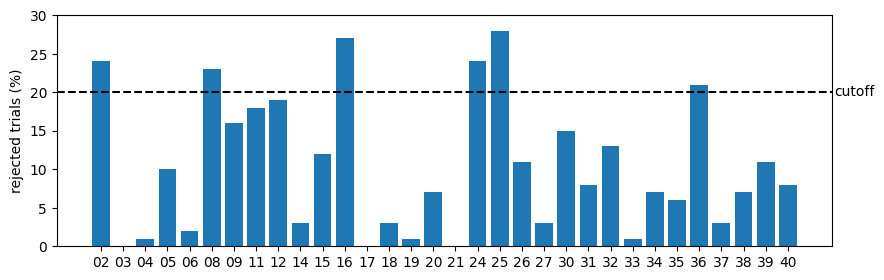


Subjects #02, #08, #16, #24, #25, #36 have more than 20% blinks / saccades.

On average, 84.0 trials were rejected (7.0%)


In [6]:
# Eye blinks & saccades
cutoff = 20 # %

# Check each subject for number of blinks & saccades 
rejected_trials = []
rejected_subjects = []
for subject in subjects:
    rejected = round(len(data[subject][data[subject]['eye tracker reject'] == 1])/len(log)*100)
    rejected_trials.append(rejected)
    if rejected > cutoff:
        rejected_subjects.append(subject)
    
# Plot percentage of rejected trials per participant
plt.subplots(figsize = (10,3))
plt.bar(subjects,rejected_trials)
plt.ylim([0,30])
plt.ylabel('rejected trials (%)')
plt.axhline(20,linestyle = 'dashed',color='black')
plt.text(len(subjects)+1.1,20,'cutoff',va='center')
plt.show()

# Report participants that are excluded from the analysis 
rejected_string = ''
for s in rejected_subjects:
    subjects.remove(s)
    rejected_string = rejected_string + '#' + str(s) + ', ' # add to 'rejected' string

rejected_string = rejected_string[:-2] # remove last comma and space
print('\nSubjects '+rejected_string+' have more than '+str(cutoff)+'% blinks / saccades.')

# Check and report the average amount of trials that were rejected
rejected_trials = []
rejected_percentage = []
for subject in subjects:
    rejected_p = round(len(data[subject][data[subject]['eye tracker reject'] == 1])/len(log)*100)
    rejected_percentage.append(rejected_p)
    rejected_t = len(data[subject][data[subject]['eye tracker reject'] == 1])
    rejected_trials.append(rejected_t)
print('\nOn average, '+str(round(np.mean(rejected_trials)))+' trials were rejected ('+str(round(np.mean(rejected_percentage)))+'%)')

### Outliers in terms of accuracy

Here, we determine if there are outliers in terms of overall accuracy, by checking the z-score of each participant. If it exceeds the cutoff of z = 3, it is considered an outlier.

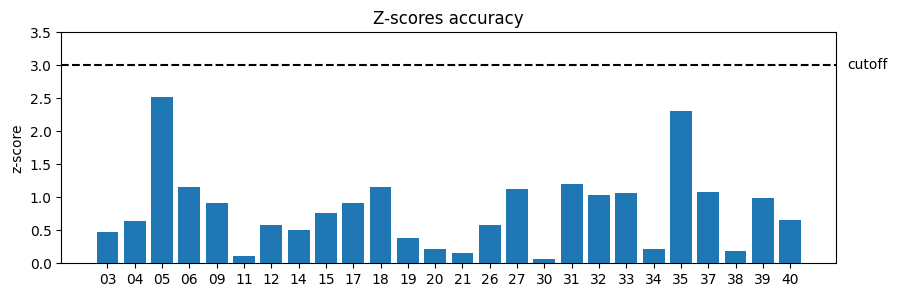

In [7]:
# Outliers in terms of accuracy
accuracy = pd.DataFrame(index = subjects, columns = ['value','z-score'], dtype = 'float64')

# Check accuracy for each subject
for subject in subjects:
    accuracy.loc[subject] = data[subject][data[subject]['eye tracker reject'] == 0]['response'].mean()

# Calculate z-scores and put them into dataframe
z_scores = abs(stats.zscore(accuracy['value']))
accuracy['z-score'] = z_scores

# Plot
plt.subplots(figsize = (10,3))
plt.bar(subjects,accuracy['z-score'])
plt.ylim([0,3.5])
plt.ylabel('z-score')
plt.title('Z-scores accuracy')
plt.axhline(3,linestyle = 'dashed',color='black')
plt.text(len(subjects)+1.1,3,'cutoff',va='center')
plt.show()

# Add participants where z > 3
outliers = np.asarray(accuracy[accuracy['z-score'] > 3].index)

# Print if participant is outlier
for outlier in outliers:
    print('\nSubject #'+outlier+' is an outlier (Z > 3)')
    subjects.remove(outlier)

### Outliers in terms of reaction time

Here, we determine if there are outliers in terms of overall reaction time, by checking the z-score of each participant. If it exceeds the cutoff of z = 3, it is considered an outlier.

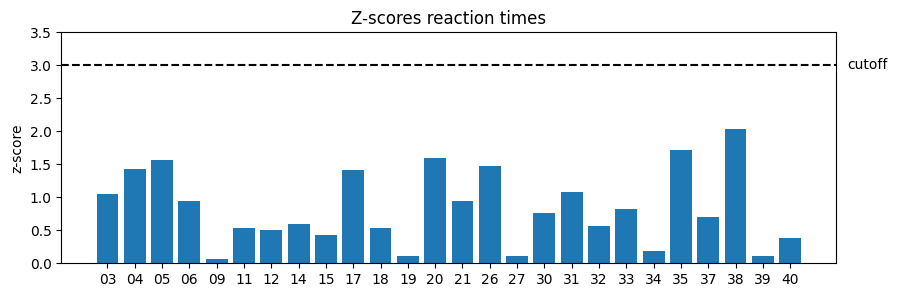

In [8]:
# Outliers in terms of response time
rt = pd.DataFrame(index = subjects, columns = ['value','z-score'], dtype = 'float64')

# Check accuracy for each subject
for subject in subjects:
    rt.loc[subject] = data[subject][data[subject]['eye tracker reject'] == 0]['reaction time'].mean()

# Calculate z-scores and put them into dataframe
z_scores = abs(stats.zscore(rt['value']))
rt['z-score'] = z_scores

# Plot
plt.subplots(figsize = (10,3))
plt.bar(subjects,rt['z-score'])
plt.ylim([0,3.5])
plt.ylabel('z-score')
plt.title('Z-scores reaction times')
plt.axhline(3,linestyle = 'dashed',color='black')
plt.text(len(subjects)+1.1,3,'cutoff',va='center')
plt.show()

# Add participants where z > 3
outliers = np.asarray(rt[rt['z-score'] > 3].index)

# Print if participant is outlier
for outlier in outliers:
    print('\nSubject #'+outlier+' is an outlier (Z>3)')
    subjects.remove(outlier)

#### New subject list after outlier rejection

In [9]:
# Print new subject list, without outliers. This can be used for later copying (to preprocessing / analysis)
print('New subject list: '+str(subjects))

New subject list: ['03', '04', '05', '06', '09', '11', '12', '14', '15', '17', '18', '19', '20', '21', '26', '27', '30', '31', '32', '33', '34', '35', '37', '38', '39', '40']


### Filtering and saving data

In [64]:
# cue validity, visual field, conditions
trials = pd.DataFrame()
for subject in subjects:
    
    # take only non-practice trials (trial code > 0), trials without blinks & saccades and correct trials
    filtered = data[subject][(data[subject]['trial'] > 0) & 
                             (data[subject]['eye tracker reject'] == 0)]

    # add subject information
    filtered['subject'] = subject
    
    # add to trials dataframe
    trials = pd.concat((trials,filtered))

# drop and rearrange columns   
columns = ['subject','condition','validity','cue side','cue-target interval','reaction time','response'] # desired columns
drop_columns = [col for col in trials.columns if col not in columns]
trials = trials.drop(columns = drop_columns)

# round cue-target interval (avoiding mismatch with logged time, creating equally spaced time points)
trials['cue-target interval'] = t[abs(trials['cue-target interval'][None, :] - t[:, None]).argmin(axis=0)]
trials['cue-target interval'] = round(trials['cue-target interval'],3)

# rearrange columns
trials = trials[columns]

# reset index
trials = trials.reset_index(drop=True)

# recode variables
trials['validity'] = trials['validity'].replace(to_replace=1,value = 'valid')
trials['validity'] = trials['validity'].replace(to_replace=0,value = 'invalid')
trials['cue side'] = trials['cue side'].replace(to_replace=1,value = 'right')
trials['cue side'] = trials['cue side'].replace(to_replace=0,value = 'left')
trials['response'] = trials['response'].replace(to_replace=1,value = 'correct')
trials['response'] = trials['response'].replace(to_replace=0,value = 'incorrect')

# show some trials
print("This is the data frame containing all trials:")
display(trials)

# Save data
file = clean_data_folder +'/trials.csv'
trials.to_csv(file, index = True, header = True)  

This is the data frame containing all trials:


,subject,condition,validity,cue side,cue-target interval,reaction time,response
0,03,60,valid,right,1.500,674.346,correct
1,03,60,valid,right,1.033,535.099,correct
2,03,60,invalid,right,1.667,677.154,correct
3,03,60,invalid,right,0.700,642.355,correct
4,03,60,valid,left,1.200,649.998,correct
...,...,...,...,...,...,...,...
27129,40,80,valid,left,1.617,456.249,correct
27130,40,80,invalid,right,0.533,809.345,correct
27131,40,80,valid,left,0.850,375.255,correct
27132,40,80,valid,right,1.067,700.346,correct


The end.